<a href="https://colab.research.google.com/github/mohitsharmas97/revision/blob/main/Optimizing_PytorchANNday6__.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fashionmnist


In [ ]:
cd /root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4

/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4


In [ ]:
ls

fashion-mnist_test.csv   t10k-images-idx3-ubyte  train-images-idx3-ubyte
fashion-mnist_train.csv  t10k-labels-idx1-ubyte  train-labels-idx1-ubyte


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
torch.manual_seed(42) #make PyTorch’s random number generator produce the same sequence every time → same initialization, same training sequence.

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device:{device}")

Using device:cuda


In [ ]:
df=pd.read_csv('fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


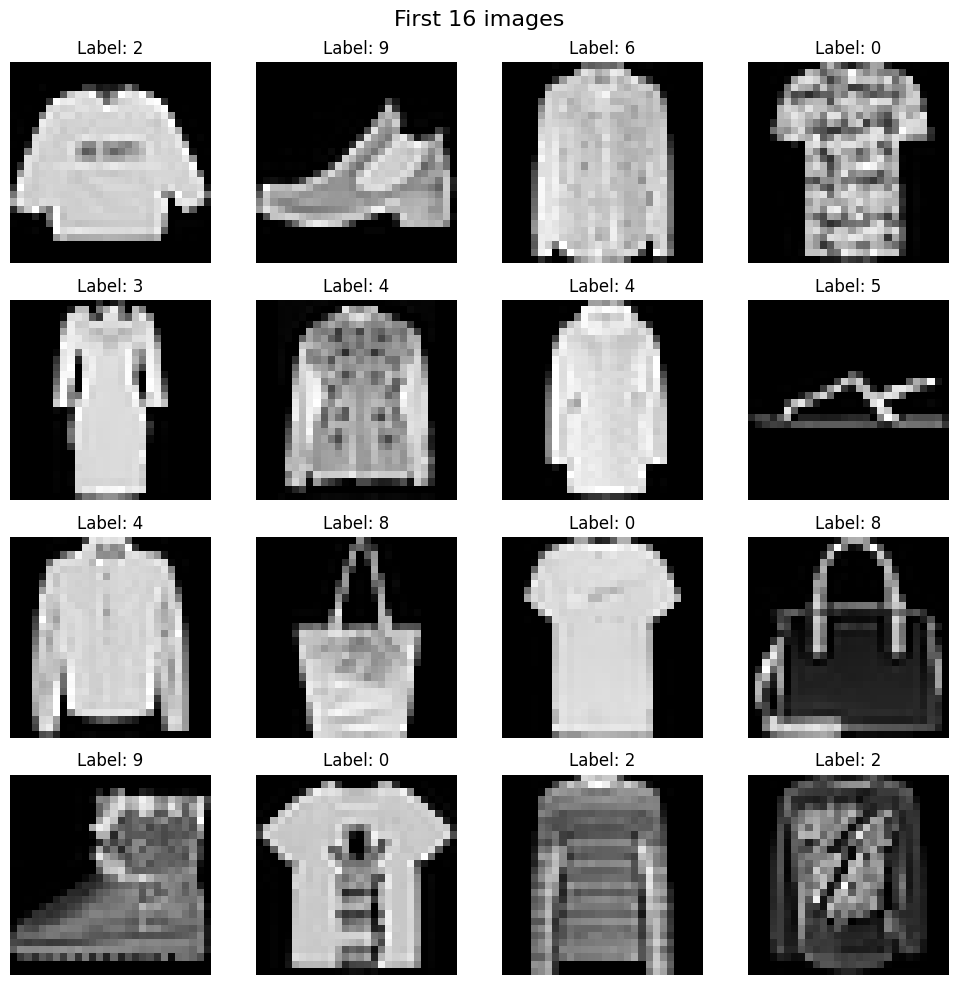

In [ ]:
fig,axes=plt.subplots(4,4,figsize=(10,10))
fig.suptitle("First 16 images",fontsize=16)

for i,ax in enumerate(axes.flat):
    imf=df.iloc[i,1:].values.reshape(28,28)
    label = df.iloc[i, 0]
    ax.imshow(imf, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Label: {label}")

plt.tight_layout()
plt.show()

In [ ]:
x=df.iloc[:,1:].values
y=df.iloc[:,0].values


In [ ]:
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
y

array([2, 9, 6, ..., 8, 8, 7])

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
#scaling the features-------------You’re making the data smaller, consistent, and easier for the model to learn from.
x_train=x_train/255.0
x_test=x_test/255.0

In [ ]:
class CustomDataset(Dataset):

  def __init__(self,features,labels):
    self.features=torch.tensor(features,dtype=torch.float32)
    self.labels=torch.tensor(labels,dtype=torch.long) # Corrected dtype to long for labels

  def __len__(self):
    return len(self.features)

  def __getitem__(self,index):
    return self.features[index],self.labels[index]

#custom dataset class

In [ ]:
train_dataset=CustomDataset(x_train,y_train)

In [ ]:
len(train_dataset)

48000

In [ ]:
test_dataset=CustomDataset(x_test,y_test)


In [ ]:
len(test_dataset)

12000

In [ ]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True,pin_memory=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False,pin_memory=True)

In [ ]:
#define NN class
class MYNN(nn.Module):
  def __init__(self,num_features):

    super().__init__()

    self.model=nn.Sequential(
        nn.Linear(num_features,128), #784,128
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(p=0.3),

        nn.Linear(128,64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(p=0.3),

        nn.Linear(64,10)
  )

  def forward(self,x):
    return self.model(x)

In [ ]:
epochs=100
learning_rate=0.1


In [ ]:
model=MYNN(x_train.shape[1])

model=model.to(device)#move to gpu

criterion=nn.CrossEntropyLoss() #CrossEntropyLoss is used for multi-class classification.

optimizer=optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4)

In [ ]:
len(train_loader)

1500

In [ ]:
#training loop

for epoch in range(epochs):
  total_epoch_loss=0
  for batch_features,batch_labels in train_loader:

    #move data to gpu
    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)


    #forward pass
    outputs=model(batch_features)

    #calculate loss
    loss=criterion(outputs,batch_labels)

    optimizer.zero_grad()

    #backward passs
    loss.backward()

    #update grads means parameter
    optimizer.step()

    total_epoch_loss+=loss.item()
    avg_loss=total_epoch_loss/len(train_loader)

  print(f'Epoch:{epoch+1},{epochs}, Loss: {avg_loss:.4f}')

Epoch:1,100, Loss: 0.6236
Epoch:2,100, Loss: 0.4927
Epoch:3,100, Loss: 0.4570
Epoch:4,100, Loss: 0.4371
Epoch:5,100, Loss: 0.4175
Epoch:6,100, Loss: 0.4015
Epoch:7,100, Loss: 0.3926
Epoch:8,100, Loss: 0.3866
Epoch:9,100, Loss: 0.3765
Epoch:10,100, Loss: 0.3711
Epoch:11,100, Loss: 0.3623
Epoch:12,100, Loss: 0.3588
Epoch:13,100, Loss: 0.3534
Epoch:14,100, Loss: 0.3519
Epoch:15,100, Loss: 0.3492
Epoch:16,100, Loss: 0.3401
Epoch:17,100, Loss: 0.3348
Epoch:18,100, Loss: 0.3333
Epoch:19,100, Loss: 0.3322
Epoch:20,100, Loss: 0.3267
Epoch:21,100, Loss: 0.3264
Epoch:22,100, Loss: 0.3209
Epoch:23,100, Loss: 0.3233
Epoch:24,100, Loss: 0.3213
Epoch:25,100, Loss: 0.3169
Epoch:26,100, Loss: 0.3172
Epoch:27,100, Loss: 0.3108
Epoch:28,100, Loss: 0.3107
Epoch:29,100, Loss: 0.3079
Epoch:30,100, Loss: 0.3084
Epoch:31,100, Loss: 0.3103
Epoch:32,100, Loss: 0.3061
Epoch:33,100, Loss: 0.3012
Epoch:34,100, Loss: 0.3006
Epoch:35,100, Loss: 0.3022
Epoch:36,100, Loss: 0.2956
Epoch:37,100, Loss: 0.3007
Epoch:38,1

In [ ]:
model.eval() #turn off the batchNormalization and dropouts

MYNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
#evaluation code

total=0
correct=0
with torch.no_grad():

  for batch_features,batch_labels in test_loader:

     #move data to gpu
     batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)

    outputs=model(batch_features)
    predicted=torch.max(outputs,1)
    total=total+batch_labels.shape[0]
    correct=correct+(predicted.indices==batch_labels).sum().item()

accuracy=correct/total
print(f'Accuracy:{accuracy*100:.2f}%')

Accuracy:89.44%


In [ ]:
#evaluation code

total=0
correct=0
with torch.no_grad():

  for batch_features,batch_labels in train_loader:

     #move data to gpu
    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)

    outputs=model(batch_features)
    predicted=torch.max(outputs,1)
    total=total+batch_labels.shape[0]
    correct=correct+(predicted.indices==batch_labels).sum().item()

accuracy=correct/total
print(f'Accuracy:{accuracy*100:.2f}%')

Accuracy:95.85%
